In [1]:
import define_rgbsample
import dispmodels
import fitDisp
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import emcee
import safe_colours
import pickle
import corner
import os
from galpy.actionAngle import actionAngleStaeckel, estimateDeltaStaeckel
from galpy.potential import MWPotential2014
from galpy.util import bovy_coords
from galpy.df import quasiisothermaldf
import tqdm
from astropy.io import fits
from astropy.table import Table, join
from scipy.stats import gaussian_kde
from scipy.integrate import quad
safe_colours = safe_colours.initialise()
col_dict = safe_colours.distinct_named()
cm_rainbow = safe_colours.colourmap('rainbow')
cm_heat = safe_colours.colourmap('heat')
cm_diverging = safe_colours.colourmap('diverging') 

params = {'axes.labelsize': 14, 'xtick.labelsize': 12, 'ytick.labelsize': 12, 'text.usetex': True, 'lines.linewidth': 1,
          'axes.titlesize': 14, 'font.family': 'serif'}
plt.rcParams.update(params)

columnwidth = 240./72.27
textwidth = 504.0/72.27

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

#cosmology 
Omega0, OmegaLambda, a_0, h = 0.307, 0.693, 1., 0.6777


def t_lookback(a):
    return a / (np.sqrt(Omega0 * a + OmegaLambda * (a ** 4)))

t_em = quad(t_lookback, 0., a_0)[0]
t_em = (1 / (h * 100)) * (3.086e19 / 3.1536e16) * t_em

def z2age(z):
    a = 1 / (1 + z)
    t = np.array([quad(t_lookback, x, a_0)[0] for x in a])
    return (1 / (h * 100)) * (3.086e19 / 3.1536e16) * t


def z2tau(z):
    a = 1 / (1 + z)
    t = np.array([quad(t_lookback, x, a_0)[0] for x in a])
    return t_em - ((1 / (h * 100)) * (3.086e19 / 3.1536e16) * t)

/home/astjmack/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


/home/astjmack/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters



In [2]:
if os.path.isfile('../sav/DR14_Gaia_astroNNAges_dists_galcencyl.npy'):
    with open('../sav/DR14_Gaia_astroNNAges_dists_galcencyl.npy', 'rb') as f:
        dat = np.load(f)
        Rpz = np.load(f)
        vRvTvz = np.load(f)
        cov_galcencyl = np.load(f)
        
##load orbit catalogue
#orbits = fits.open('/gal/sdss_lsm/APOGEE_gaiarvs_orbitparams.fits')
##cross match with Gaia-APOGEE
#allStar_tab = Table(data=dat)
#orbits_tab = Table(data=orbits[1].data)
#tab = join(allStar_tab, orbits_tab, 
#                   keys='APOGEE_ID', 
#                   uniq_col_name='{col_name}{table_name}', 
#                   table_names=['','_orbits'])
#dat = tab.as_array()
#print('%i stars with orbits...' % len(dat))
#

mp = MWPotential2014
deltas = estimateDeltaStaeckel(mp, Rpz[:,0], Rpz[:,2], no_median=True)

aAS = actionAngleStaeckel(pot=mp, delta=0.4)
e, Zmax, rperi, rap = aAS.EccZmaxRperiRap(Rpz[:,0], vRvTvz[:,0] , vRvTvz[:,1], Rpz[:,2], vRvTvz[:,2], Rpz[:,1], delta=deltas)

In [3]:
if os.path.isfile('../sav/apdr14gaiadr2_astroNN_ages_distances_ellipsoid_fixedv0_monoage_sgrvsun.npy'):
    with open('../sav/apdr14gaiadr2_astroNN_ages_distances_ellipsoid_fixedv0_monoage_sgrvsun.npy', 'rb') as f:
        lo_samples = np.load(f)
        hi_samples = np.load(f)
        co_samples = np.load(f)
        lo_med_z = np.load(f)
        hi_med_z = np.load(f)
        co_med_z = np.load(f)
        
agebins = np.arange(1.,14.,1.5)
fehbins = np.arange(-0.6,0.6,0.1)

lo_par = np.empty([len(agebins)-1,len(fehbins)-1,11,3])
hi_par = np.empty([len(agebins)-1,len(fehbins)-1,11,3])
co_par = np.empty([len(agebins)-1,len(fehbins)-1,11,3])
for i in range(len(agebins)-1):
    for j in range(len(fehbins)-1):
        lo_par[i,j] = np.nanpercentile(lo_samples[i,j], [16,50,84], axis=0).T
        hi_par[i,j] = np.nanpercentile(hi_samples[i,j], [16,50,84], axis=0).T
        co_par[i,j] = np.nanpercentile(co_samples[i,j], [16,50,84], axis=0).T

co_nbins = np.zeros([len(agebins)-1, len(fehbins)-1])
lo_nbins = np.zeros([len(agebins)-1, len(fehbins)-1])
hi_nbins = np.zeros([len(agebins)-1, len(fehbins)-1])
co_alpha = np.zeros([len(agebins)-1, len(fehbins)-1])
lo_alpha = np.zeros([len(agebins)-1, len(fehbins)-1])
hi_alpha = np.zeros([len(agebins)-1, len(fehbins)-1])
co_rmean = np.zeros([len(agebins)-1, len(fehbins)-1])
lo_rmean = np.zeros([len(agebins)-1, len(fehbins)-1])
hi_rmean = np.zeros([len(agebins)-1, len(fehbins)-1])


for i in range(len(agebins)-1):
    for j in range(len(fehbins)-1):
        co_nbins[i,j] = np.sum([(dat['Age'] > agebins[i]) & (dat['Age'] < agebins[i+1]) & (dat['FE_H'] > fehbins[j]) & (dat['FE_H'] < fehbins[j+1])])
        lo_nbins[i,j] = np.sum([(dat['Age'] > agebins[i]) & (dat['Age'] < agebins[i+1]) & (dat['FE_H'] > fehbins[j]) & (dat['FE_H'] < fehbins[j+1]) & (dat['AVG_ALPHAFE'] < define_rgbsample.alphaedge(dat['FE_H']))])
        hi_nbins[i,j] = np.sum([(dat['Age'] > agebins[i]) & (dat['Age'] < agebins[i+1]) & (dat['FE_H'] > fehbins[j]) & (dat['FE_H'] < fehbins[j+1]) & (dat['AVG_ALPHAFE'] > define_rgbsample.alphaedge(dat['FE_H'])+0.04)])
        co_alpha[i,j] = np.median(dat['AVG_ALPHAFE'][(dat['Age'] > agebins[i]) & (dat['Age'] < agebins[i+1]) & (dat['FE_H'] > fehbins[j]) & (dat['FE_H'] < fehbins[j+1])])
        lo_alpha[i,j] = np.median(dat['AVG_ALPHAFE'][(dat['Age'] > agebins[i]) & (dat['Age'] < agebins[i+1]) & (dat['FE_H'] > fehbins[j]) & (dat['FE_H'] < fehbins[j+1]) & (dat['AVG_ALPHAFE'] < define_rgbsample.alphaedge(dat['FE_H']))])
        hi_alpha[i,j] = np.median(dat['AVG_ALPHAFE'][(dat['Age'] > agebins[i]) & (dat['Age'] < agebins[i+1]) & (dat['FE_H'] > fehbins[j]) & (dat['FE_H'] < fehbins[j+1]) & (dat['AVG_ALPHAFE'] > define_rgbsample.alphaedge(dat['FE_H'])+0.04)])
        co_rmean[i,j] = np.nanmedian((rperi+rap)[(dat['Age'] > agebins[i]) & (dat['Age'] < agebins[i+1]) & (dat['FE_H'] > fehbins[j]) & (dat['FE_H'] < fehbins[j+1])]/2.)
        lo_rmean[i,j] = np.nanmedian((rperi+rap)[(dat['Age'] > agebins[i]) & (dat['Age'] < agebins[i+1]) & (dat['FE_H'] > fehbins[j]) & (dat['FE_H'] < fehbins[j+1]) & (dat['AVG_ALPHAFE'] < define_rgbsample.alphaedge(dat['FE_H']))]/2.)
        hi_rmean[i,j] = np.nanmedian((rperi+rap)[(dat['Age'] > agebins[i]) & (dat['Age'] < agebins[i+1]) & (dat['FE_H'] > fehbins[j]) & (dat['FE_H'] < fehbins[j+1]) & (dat['AVG_ALPHAFE'] > define_rgbsample.alphaedge(dat['FE_H'])+0.04)]/2.)


/home/astjmack/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)

/home/astjmack/anaconda3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1019: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



/home/astjmack/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  



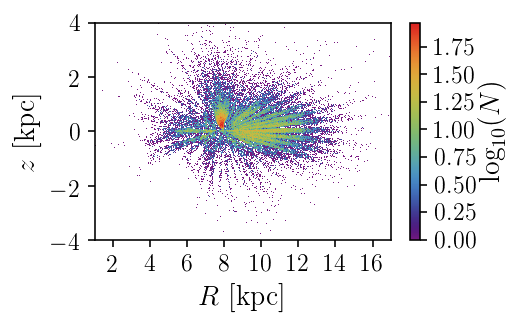

In [4]:
fig = plt.figure()
fig.set_size_inches(columnwidth,0.6*columnwidth)
xbins, ybins = np.linspace(1.,17.,300), np.linspace(-4,4.,300)

hist, xedges, yedges = np.histogram2d(Rpz[:,0]*8., Rpz[:,2]*8., bins=[xbins,ybins])
plt.imshow(np.rot90(np.log10(hist)), extent=[1.,17.,-4,4.], cmap=cm_rainbow, aspect='auto')
plt.xticks([2,4,6,8,10,12,14,16])
plt.colorbar(label=r'$\log_{10}(N)$')
plt.ylabel(r'$z\ \mathrm{[kpc]}$')
plt.xlabel(r'$R\ \mathrm{[kpc]}$')

plt.savefig('../plots/Rz_distribution.png', format='png', dpi=400, bbox_inches='tight')
plt.savefig('../plots/Rz_distribution.pdf', format='pdf', dpi=400, bbox_inches='tight')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


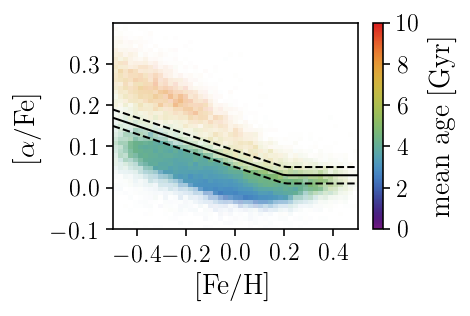

In [11]:
tafebins = np.linspace(-0.1,0.35,50)
tfehbins = np.linspace(-0.5,0.5,50)
norm = matplotlib.colors.Normalize(vmin=0.,vmax=10.)
s_m1 = matplotlib.cm.ScalarMappable(cmap=cm_rainbow, norm=norm)
s_m1.set_array([]) 
fig = plt.figure()
fig.set_size_inches(columnwidth,0.7*columnwidth)
hist, yedges, xedges = np.histogram2d(dat['FE_H'], dat['AVG_ALPHAFE'], bins=[tfehbins,tafebins])
mhist, yedges, xedges = np.histogram2d(dat['FE_H'], dat['AVG_ALPHAFE'], bins=[tfehbins,tafebins], weights=dat['Age'])
colors = s_m1.to_rgba((np.rot90(mhist/hist)))
colors[:,:,3] = np.rot90(hist/(0.3*np.max(hist)))
plt.imshow(colors, extent=[-0.5,0.5,-0.1,0.4], aspect='auto', interpolation='Nearest')
plt.colorbar(s_m1,label=r'$\mathrm{mean\ age\ [Gyr]}$')
plt.plot(tfehbins, define_rgbsample.alphaedge(tfehbins)+0.04, color='Black', linestyle='dashed')
plt.plot(tfehbins, define_rgbsample.alphaedge(tfehbins), color='Black', linestyle='dashed')
plt.plot(tfehbins, define_rgbsample.alphaedge(tfehbins)+0.02, color='Black')
plt.xticks([-0.4,-0.2,0.,0.2,0.4])
plt.yticks([-0.1,0.,0.1,0.2,0.3])
plt.xlabel(r'$\mathrm{[Fe/H]}$')
plt.ylabel(r'$\mathrm{[\alpha/Fe]}$')
fig.tight_layout()

plt.savefig('../plots/afe_feh_meanage.png', format='png', dpi=400)
plt.savefig('../plots/afe_feh_meanage.pdf', format='pdf', dpi=400)




Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


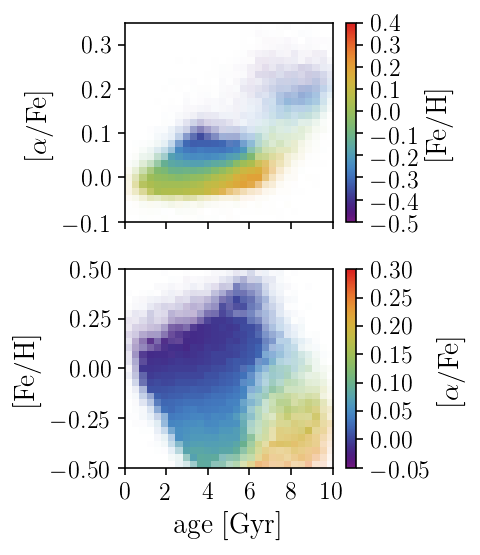

In [10]:
fig, ax = plt.subplots(2,1,sharex=True)
fig.set_size_inches(1.*columnwidth,1.2*columnwidth)

norm = matplotlib.colors.Normalize(vmin=-0.5,vmax=0.4)
s_m1 = matplotlib.cm.ScalarMappable(cmap=cm_rainbow, norm=norm)
s_m1.set_array([]) 
xbins,ybins = np.linspace(0.,10.,30), np.linspace(-0.1,0.35,30)
hist, xedges, yedges = np.histogram2d(dat['Age'], dat['AVG_ALPHAFE'], bins=[xbins,ybins])
mhist, xedges, yedges = np.histogram2d(dat['Age'], dat['AVG_ALPHAFE'], bins=[xbins,ybins], weights=dat['FE_H'])
colors = s_m1.to_rgba((np.rot90(mhist/hist)))
colors[:,:,3] = np.rot90(hist/(0.3*np.max(hist)))
ax[0].imshow(colors, extent=[0.,10.,-0.1,0.35], aspect='auto')
#s1 = ax[0].scatter(dat['Age'], dat['AVG_ALPHAFE'], lw=0., s=2, c=dat['FE_H'], vmin=-0.5,vmax=0.4, cmap=cm_rainbow, rasterized=True)
norm = matplotlib.colors.Normalize(vmin=-0.05,vmax=0.3)
s_m2 = matplotlib.cm.ScalarMappable(cmap=cm_rainbow, norm=norm)
s_m2.set_array([]) 
xbins,ybins = np.linspace(0.,10.,30), np.linspace(-0.5,0.5,30)
hist, xedges, yedges = np.histogram2d(dat['Age'], dat['FE_H'], bins=[xbins,ybins])
mhist, xedges, yedges = np.histogram2d(dat['Age'], dat['FE_H'], bins=[xbins,ybins], weights=dat['AVG_ALPHAFE'])
colors = s_m2.to_rgba((np.rot90(mhist/hist)))
colors[:,:,3] = np.rot90(hist/(0.3*np.max(hist)))
ax[1].imshow(colors, extent=[0.,10.,-0.5,0.5], aspect='auto')
#s2 = ax[1].scatter(dat['Age'], dat['FE_H'], lw=0., s=2, c=dat['AVG_ALPHAFE'], vmin=-0.05,vmax=0.3, cmap=cm_rainbow, rasterized=True)
ax[1].set_xlim(0.,10.)
ax[1].set_ylim(-0.5,0.5)
ax[0].set_ylim(-0.1,0.35)
ax[0].set_yticks([-0.1,0,0.1,0.2,0.3])
ax[0].set_ylabel(r'$\mathrm{[\alpha/Fe]}$')
ax[1].set_ylabel(r'$\mathrm{[Fe/H]}$')
ax[1].set_xlabel(r'$\mathrm{age\ [Gyr]}$')
ax[1].set_xticks([0,2,4,6,8,10])
plt.colorbar(s_m1, ax=ax[0], label=r'$\mathrm{[Fe/H]}$')
plt.colorbar(s_m2, ax=ax[1], label=r'$\mathrm{[\alpha/Fe]}$')

fig.tight_layout()
plt.savefig('../plots/GaiaAPOGEE_agefehafe.pdf', format='pdf')
plt.savefig('../plots/GaiaAPOGEE_agefehafe.png', format='png', dpi=400)

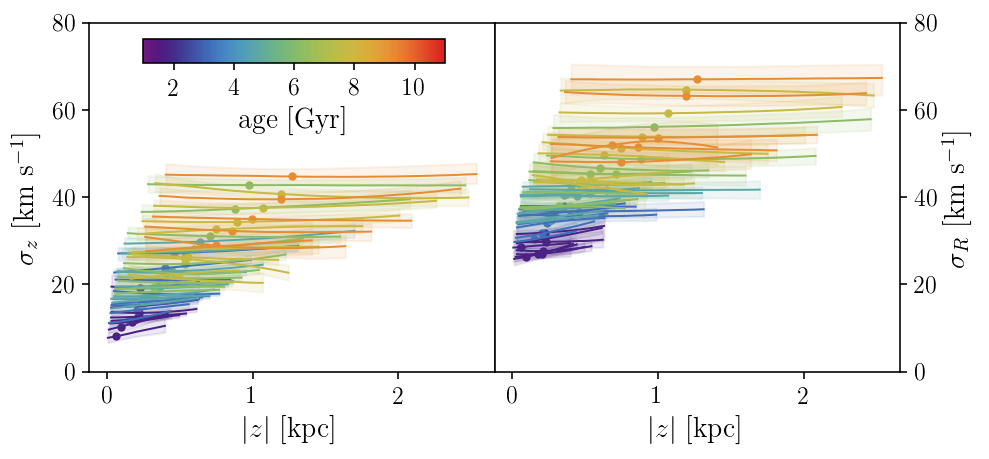

In [5]:
agegrid = (np.ones([len(agebins)-1, len(fehbins)-1]).T*((agebins[1:]+agebins[:-1])/2.)).T
fehgrid = (np.ones([len(agebins)-1, len(fehbins)-1])*((fehbins[1:]+fehbins[:-1])/2.))


def sigma_profile(zs, a,b,c,med_z):
    prof = a*(zs-med_z)**2+b*(zs-med_z)+c
    return prof

def gen_sigma_profs(samples, med_z, sigmar=False):
    zs = np.linspace(med_z[0], med_z[4], 50)
    profs = np.zeros([len(samples),len(zs)])
    mz = med_z[2]
    for i in range(len(samples)):
        if sigmar:
            profs[i] = sigma_profile(zs, samples[i,2], samples[i,3], 10**samples[i,1], mz)
        else:
            profs[i] = sigma_profile(zs, samples[i,6], samples[i,7], 10**samples[i,5], mz)
    return zs, profs
  
norm = matplotlib.colors.Normalize(
    vmin=1.,
    vmax=11.)

# choose a colormap
c_m = matplotlib.cm.viridis

# create a ScalarMappable and initialize a data structure
s_m = matplotlib.cm.ScalarMappable(cmap=cm_rainbow, norm=norm)
s_m.set_array([])   

fig,ax = plt.subplots(1,2, sharex=True)
fig.set_size_inches(textwidth,columnwidth)
for i in range(len(agebins)-1):
    for j in range(len(fehbins)-1):
        zs, profs = gen_sigma_profs(co_samples[i,j], co_med_z[i,j])
        ax[0].plot(zs, np.median(profs, axis=0), color=s_m.to_rgba(agegrid[i,j]))
        ax[0].fill_between(zs, np.percentile(profs, 16, axis=0), np.percentile(profs, 84, axis=0), color=s_m.to_rgba(agegrid[i,j]), alpha=0.1)
        ax[0].scatter(co_med_z[i,j,2], 10**np.median(co_samples[i,j,:,5]), color=s_m.to_rgba(agegrid[i,j]), s=10)
        zs, profs = gen_sigma_profs(co_samples[i,j], co_med_z[i,j], sigmar=True)
        ax[1].plot(zs, np.median(profs, axis=0), color=s_m.to_rgba(agegrid[i,j]))
        ax[1].fill_between(zs, np.percentile(profs, 16, axis=0), np.percentile(profs, 84, axis=0), color=s_m.to_rgba(agegrid[i,j]), alpha=0.1)
        ax[1].scatter(co_med_z[i,j,2], 10**np.median(co_samples[i,j,:,1]), color=s_m.to_rgba(agegrid[i,j]), s=10)
        
ax[0].set_xlabel(r'$|z|\ \mathrm{[kpc]}$')
ax[1].set_xlabel(r'$|z|\ \mathrm{[kpc]}$')
ax[0].set_ylabel(r'$\sigma_{z}\ \mathrm{[km\ s^{-1}]}$')
ax[1].set_ylabel(r'$\sigma_{R}\ \mathrm{[km\ s^{-1}]}$')
ax[0].set_ylim(0.,80.)
ax[1].set_ylim(0.,80.)
ax[1].yaxis.tick_right()
ax[1].yaxis.set_label_position('right')
fig.tight_layout()
fig.subplots_adjust(wspace=0.)
cax= fig.add_axes([0.15,0.85,0.3,0.05])
plt.colorbar(s_m, cax=cax,label=r'$\mathrm{age\ [Gyr]}$', orientation='horizontal')

plt.savefig('../plots/sigma_fz_combined_DR2_astronn_dist.png', format='png', dpi=400)
plt.savefig('../plots/sigma_fz_combined_DR2_astronn_dist.pdf', format='pdf', dpi=400)



/home/astjmack/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "



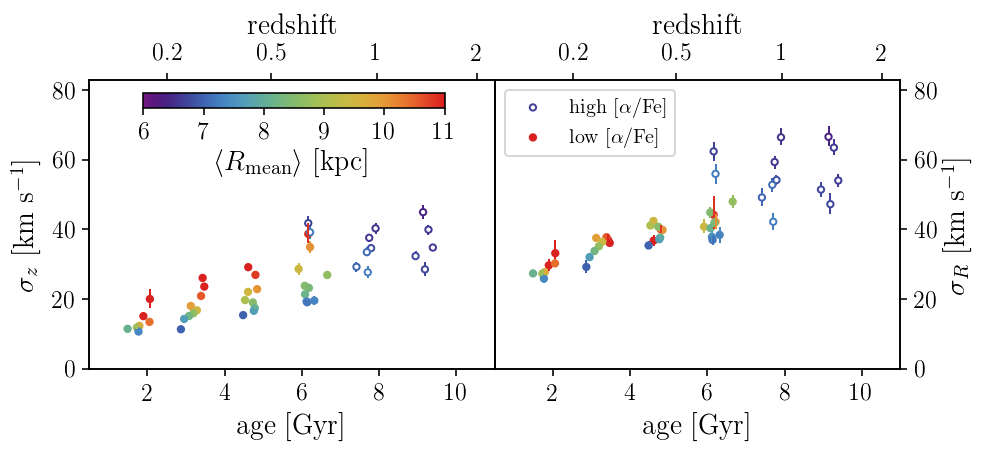

In [8]:
jitter = np.random.randn(len(agegrid.ravel()[mask]))

jitter = np.random.randn(len(agegrid.ravel()))



norm = matplotlib.colors.Normalize(
    vmin=6,
    vmax=11)

# choose a colormap
c_m = matplotlib.cm.viridis

# create a ScalarMappable and initialize a data structure
s_m = matplotlib.cm.ScalarMappable(cmap=cm_rainbow, norm=norm)
s_m.set_array([]) 

fig, ax = plt.subplots(1,2)
fig.set_size_inches(textwidth,columnwidth)

mask = hi_nbins.ravel() > 200
yerr = np.dstack([10**hi_par[:,:,5,1].ravel()[mask]-10**hi_par[:,:,5,0].ravel()[mask], 10**hi_par[:,:,5,2].ravel()[mask]-10**hi_par[:,:,5,1].ravel()[mask]])[0].T
x = agegrid.ravel()[mask]+0.2*jitter[mask]
y = 10**hi_par[:,:,5,1].ravel()[mask]
c = ax[0].scatter(x, y, s=10, edgecolor=s_m.to_rgba(hi_rmean.ravel()[mask]*8.), facecolor='White', zorder=2)
ax[0].errorbar(x, y, yerr=yerr, fmt='None', ecolor=s_m.to_rgba(hi_rmean.ravel()[mask]*8.), lw=1.,zorder=1)

mask = lo_nbins.ravel() > 200
yerr = np.dstack([10**lo_par[:,:,5,1].ravel()[mask]-10**lo_par[:,:,5,0].ravel()[mask], 10**lo_par[:,:,5,2].ravel()[mask]-10**lo_par[:,:,5,1].ravel()[mask]])[0].T
x = agegrid.ravel()[mask]+0.2*jitter[mask]
y = 10**lo_par[:,:,5,1].ravel()[mask]
c = ax[0].scatter(x, y, s=10, c=s_m.to_rgba(lo_rmean.ravel()[mask]*8.) )
ax[0].errorbar(x, y, yerr=yerr, fmt='None', ecolor=s_m.to_rgba(lo_rmean.ravel()[mask]*8.), lw=1.)



ax[0].set_ylabel(r'$\sigma_{z}\ \mathrm{[km\ s^{-1}]}$')
ax[0].set_xlabel(r'$\mathrm{age\ [Gyr]}$')
fig.tight_layout()

mask = hi_nbins.ravel() > 200
yerr = np.dstack([10**hi_par[:,:,1,1].ravel()[mask]-10**hi_par[:,:,1,0].ravel()[mask], 10**hi_par[:,:,1,2].ravel()[mask]-10**hi_par[:,:,1,1].ravel()[mask]])[0].T
y = 10**hi_par[:,:,1,1].ravel()[mask]
x = agegrid.ravel()[mask]+0.2*jitter[mask]
c = ax[1].scatter(x, y, s=10, edgecolor=s_m.to_rgba(hi_rmean.ravel()[mask]*8.) , facecolor='White', zorder=2, label=r'$\mathrm{high\ [\alpha/Fe]}$')
ax[1].errorbar(x, y, yerr=yerr, fmt='None', ecolor=s_m.to_rgba(hi_rmean.ravel()[mask]*8.), lw=1., zorder=1)

mask = lo_nbins.ravel() > 200
yerr = np.dstack([10**lo_par[:,:,1,1].ravel()[mask]-10**lo_par[:,:,1,0].ravel()[mask], 10**lo_par[:,:,1,2].ravel()[mask]-10**lo_par[:,:,1,1].ravel()[mask]])[0].T
y = 10**lo_par[:,:,1,1].ravel()[mask]
x = agegrid.ravel()[mask]+0.2*jitter[mask]
c = ax[1].scatter(x, y, s=10, c=s_m.to_rgba(lo_rmean.ravel()[mask]*8.) , label=r'$\mathrm{low\ [\alpha/Fe]}$')
ax[1].errorbar(x, y, yerr=yerr, fmt='None', ecolor=s_m.to_rgba(lo_rmean.ravel()[mask]*8.), lw=1.)

ax[1].legend(frameon=True)
ax[1].yaxis.tick_right()
ax[1].yaxis.set_label_position('right')

ax[1].set_ylabel(r'$\sigma_{R}\ \mathrm{[km\ s^{-1}]}$')
ax[1].set_xlabel(r'$\mathrm{age\ [Gyr]}$')
fig.tight_layout()
fig.subplots_adjust(wspace=0.)
cax = fig.add_axes([0.15,0.75,0.3,0.03])
cb = plt.colorbar(s_m, label=r'$\langle R_{\mathrm{mean}}\rangle\ \mathrm{[kpc]}$', cax=cax, orientation='horizontal')
#cb.ax.xaxis.set_ticks_position('top')
#cb.ax.xaxis.set_label_position('top')
ax[0].set_ylim(0,83)
ax[1].set_ylim(0,83)
ax[0].set_xlim(0.5,11)
ax[1].set_xlim(0.5,11)


ax[0].set_xticks([2,4,6,8,10])
ax[1].set_xticks([2,4,6,8,10])


twin = ax[0].twiny()
twin.set_xlim(ax[0].get_xlim())
a_s = 1/(1+np.array([0.,2.,4.]))
twin.set_xticks(z2age(np.array([0.,0.2,0.5,1.,2.])))
labels = ['0','0.2','0.5','1','2']
twin.set_xticklabels(labels)
twin.set_xlabel(r'$\mathrm{redshift}$')
twin.set_xlim(ax[0].get_xlim())


twin = ax[1].twiny()
twin.set_xlim(ax[1].get_xlim())
a_s = 1/(1+np.array([0.,2.,4.]))
twin.set_xticks(z2age(np.array([0.2,0.5,1.,2.])))
labels = ['0.2','0.5','1','2']
twin.set_xticklabels(labels)
twin.set_xlabel(r'$\mathrm{redshift}$')
twin.set_xlim(ax[1].get_xlim())

fig.tight_layout()
fig.subplots_adjust(wspace=0.)


plt.savefig('../plots/sigma_z_sigma_R_age_alphasplit.png', format='png', dpi=400, bbox_inches='tight')
plt.savefig('../plots/sigma_z_sigma_R_age_alphasplit.pdf', format='pdf', dpi=400, bbox_inches='tight')





In [19]:
#this cell fits the power-law AVRs to the points in the above plots

import emcee


def powerlaw(age,beta,sigma_10):
    return sigma_10*(age/10)**(beta)

def lnlike(theta, x, y, yerr):
    beta, sigma_10 = theta
    model = powerlaw(x,1/beta, sigma_10)
    inv_sigma2 = 1./yerr
    return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(inv_sigma2)))

def lnprior(theta):
    beta, sigma_10 = theta
    if -5.0 < 1/beta < 5. and 0.0 < sigma_10 < 100.0:
        return 0.0
    return -np.inf

def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)

zbetas = np.ones(len(agegrid[0,:]))*np.nan
zbeta_errs = np.ones(len(agegrid[0,:]))*np.nan
meanrmean = np.ones(len(agegrid[0,:]))*np.nan
meanrmean_r = np.ones(len(agegrid[0,:]))*np.nan
fehs = np.ones(len(agegrid[0,:]))*np.nan
betasampls = []
for i in range(len(agegrid[0,:])):
    nbins = lo_nbins[:,i]
    if (nbins < 200).all():
        continue
    x = agegrid[:,0]
    y = 10**lo_par[:,:,5,1][:,i]
    mask = np.isfinite(y) & (nbins > 200)
    if np.sum(mask) < 3:
        continue
    yerr = 10**lo_par[:,:,5,2][:,i]-10**lo_par[:,:,5,0][:,i]
    import scipy.optimize as op
    nll = lambda *args: -lnlike(*args)
    result = op.minimize(nll, [1/0.2,20.], args=(x[mask], y[mask], yerr[mask]))
    beta, sigma_10 = result["x"]
    print(result['x'])
    ndim, nwalkers = 2, 100
    pos = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(x[mask], y[mask], yerr[mask]))
    sampler.run_mcmc(pos, 100)
    samples = sampler.chain[:, 50:, :].reshape((-1, ndim))
    beta = np.median(1/samples[:,0])
    sigma_10 = np.median(samples[:,1])
    zbetas[i] = beta
    zbeta_errs[i] = np.std(1/samples[:,0])
    meanrmean[i] = np.mean(lo_rmean[:,i][mask]*8.)
    meanrmean_r[i] = np.std(lo_rmean[:,i][mask]*8.)
    fehs[i] = fehgrid[0,:][i]
    betasampls.extend(samples[:,0])


# create a ScalarMappable and initialize a data structure
betas = np.ones(len(agegrid[0,:]))*np.nan
beta_errs = np.ones(len(agegrid[0,:]))*np.nan
meanrmean = np.ones(len(agegrid[0,:]))*np.nan
meanrmean_r = np.ones(len(agegrid[0,:]))*np.nan
fehs = np.ones(len(agegrid[0,:]))*np.nan
for i in range(len(agegrid[0,:])):
    nbins = lo_nbins[:,i]
    if (nbins < 200).all():
        continue
    x = agegrid[:,0]
    y = 10**lo_par[:,:,1,1][:,i]
    mask = np.isfinite(y) & (nbins > 200)
    if np.sum(mask) < 3:
        continue
    yerr = 10**lo_par[:,:,1,2][:,i]-10**lo_par[:,:,1,0][:,i]
    import scipy.optimize as op
    nll = lambda *args: -lnlike(*args)
    result = op.minimize(nll, [1/0.2,20.], args=(x[mask], y[mask], yerr[mask]))
    beta, sigma_10 = result["x"]
    print(result['x'])
    ndim, nwalkers = 2, 100
    pos = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(x[mask], y[mask], yerr[mask]))
    sampler.run_mcmc(pos, 100)
    samples = sampler.chain[:, 50:, :].reshape((-1, ndim))
    beta = np.median(1/samples[:,0])
    sigma_10 = np.median(samples[:,1])
    betas[i] = beta
    beta_errs[i] = np.std(1/samples[:,0])
    meanrmean[i] = np.mean(lo_rmean[:,i][mask]*8.)
    meanrmean_r[i] = np.std(lo_rmean[:,i][mask]*8.)
    fehs[i] = fehgrid[0,:][i]


[ 1.76947548 47.3324408 ]
[ 2.08038677 40.75151161]
[ 2.20283092 33.75333582]
[ 1.83899816 33.70970131]
[ 1.98950147 29.39884349]
[ 1.9165526  28.81624684]
[ 2.10636847 25.78020876]
[ 2.17841537 23.7338437 ]
[ 1.25472857 27.79273408]
[ 5.08554465 44.98589918]
[ 4.79062191 46.39790743]
[ 4.25891668 47.29217887]
[ 2.80789482 55.98165077]
[ 2.67752379 54.28863491]
[ 2.90017838 51.0937507 ]
[ 3.28284934 47.03843394]
[ 3.18422799 45.54287584]
[ 2.89703466 44.32922325]


/home/astjmack/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "



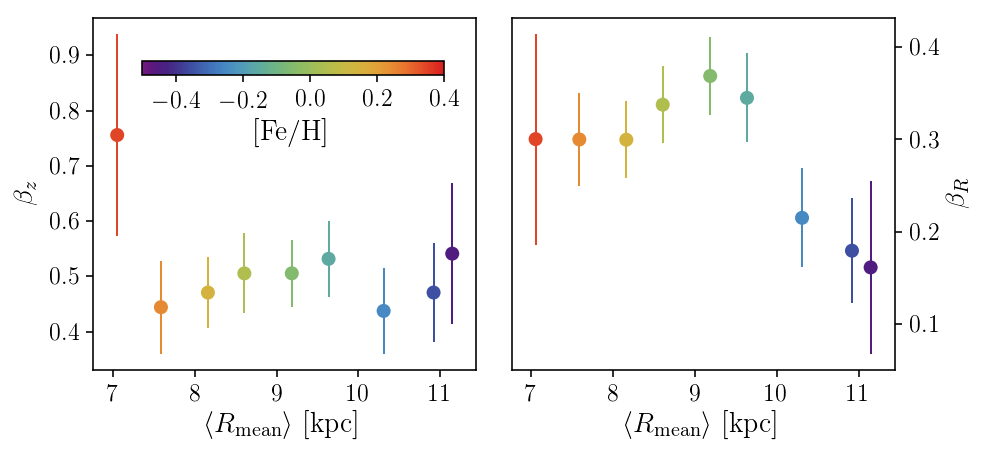

In [21]:
#plot the AVR slope against R_mean for low [a/Fe] pops.

fig, ax  = plt.subplots(1,2, sharex=True)
fig.set_size_inches(textwidth,columnwidth)
norm = matplotlib.colors.Normalize(
    vmin=-0.5,
    vmax=0.4)

c_m = matplotlib.cm.viridis

s_m = matplotlib.cm.ScalarMappable(cmap=cm_rainbow, norm=norm)
s_m.set_array([]) 
mask = np.isfinite(fehs)
ax[1].errorbar(meanrmean[mask], betas[mask], yerr=beta_errs[mask], fmt='None', ecolor=s_m.to_rgba(fehs[mask]))
ax[1].scatter(meanrmean[mask], betas[mask], c=s_m.to_rgba(fehs[mask]))
ax[1].set_xlabel(r'$\langle R_{\mathrm{mean}} \rangle\ \mathrm{[kpc]}$')
ax[1].set_ylabel(r'$\beta_R$')

ax[0].errorbar(meanrmean[mask], zbetas[mask], yerr=zbeta_errs[mask], fmt='None', ecolor=s_m.to_rgba(fehs[mask]))
ax[0].scatter(meanrmean[mask], zbetas[mask], c=s_m.to_rgba(fehs[mask]))
ax[0].set_xlabel(r'$\langle R_{\mathrm{mean}} \rangle\ \mathrm{[kpc]}$')
ax[0].set_ylabel(r'$\beta_z$')


ax[1].yaxis.tick_right()
ax[1].yaxis.set_label_position('right')

cax = fig.add_axes([0.15,0.82,0.3,0.03])
plt.colorbar(s_m, cax=cax, label=r'$\mathrm{[Fe/H]}$', orientation='horizontal', ticks=[-0.4,-0.2,0.,0.2,0.4])

fig.tight_layout()
plt.savefig('../plots/beta_r_mean.png', format='png', dpi=400, bbox_inches='tight')
plt.savefig('../plots/beta_r_mean.pdf', format='pdf', dpi=400, bbox_inches='tight')

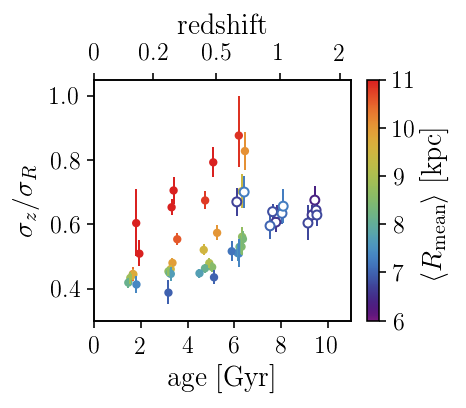

In [12]:
norm = matplotlib.colors.Normalize(
    vmin=6,
    vmax=11)

# choose a colormap
c_m = matplotlib.cm.viridis

# create a ScalarMappable and initialize a data structure
s_m = matplotlib.cm.ScalarMappable(cmap=cm_rainbow, norm=norm)
s_m.set_array([]) 

fig = plt.figure()
fig.set_size_inches(1.*columnwidth,0.9*columnwidth)
mask = lo_nbins.ravel() > 200
yerr = np.dstack([10**lo_par[:,:,1,0].ravel()[mask]-10**lo_par[:,:,1,1].ravel()[mask], 10**lo_par[:,:,1,2].ravel()[mask]-10**lo_par[:,:,1,1].ravel()[mask]])[0].T
yerr_1 = np.dstack([10**lo_par[:,:,5,0].ravel()[mask]-10**lo_par[:,:,5,1].ravel()[mask], 10**lo_par[:,:,5,0].ravel()[mask]-10**lo_par[:,:,5,1].ravel()[mask]])[0].T
co_val = 10**lo_par[:,:,5,1].ravel()[mask]/10**lo_par[:,:,1,1].ravel()[mask]
hi_yerr = co_val*np.sqrt((yerr/10**lo_par[:,:,1,1].ravel()[mask])**2+(yerr_1/10**lo_par[:,:,5,1].ravel()[mask])**2)
jitter = np.random.randn(len(agegrid.ravel()[mask]))
c = plt.scatter(agegrid.ravel()[mask]+0.2*jitter, co_val, s=10, c=s_m.to_rgba(lo_rmean.ravel()[mask]*8.) )
plt.errorbar(agegrid.ravel()[mask]+0.2*jitter, co_val, yerr=hi_yerr, fmt='None', ecolor=s_m.to_rgba(lo_rmean.ravel()[mask]*8.), lw=1.)

mask = hi_nbins.ravel() > 200
yerr = np.dstack([10**hi_par[:,:,1,0].ravel()[mask]-10**hi_par[:,:,1,1].ravel()[mask], 10**hi_par[:,:,1,2].ravel()[mask]-10**hi_par[:,:,1,1].ravel()[mask]])[0].T
yerr_1 = np.dstack([10**hi_par[:,:,5,0].ravel()[mask]-10**hi_par[:,:,5,1].ravel()[mask], 10**hi_par[:,:,5,0].ravel()[mask]-10**hi_par[:,:,5,1].ravel()[mask]])[0].T
co_val = 10**hi_par[:,:,5,1].ravel()[mask]/10**hi_par[:,:,1,1].ravel()[mask]
hi_yerr = co_val*np.sqrt((yerr/10**hi_par[:,:,1,1].ravel()[mask])**2+(yerr_1/10**hi_par[:,:,5,1].ravel()[mask])**2)
jitter = np.random.randn(len(agegrid.ravel()[mask]))
c = plt.scatter(agegrid.ravel()[mask]+0.2*jitter, co_val, s=20, edgecolor=s_m.to_rgba(hi_rmean.ravel()[mask]*8.), facecolor='White', zorder=2)
plt.errorbar(agegrid.ravel()[mask]+0.2*jitter, co_val, yerr=hi_yerr, fmt='None', ecolor=s_m.to_rgba(hi_rmean.ravel()[mask]*8.), lw=1., zorder=1)
plt.ylim(0.3,1.05)
plt.colorbar(s_m, label=r'$\langle R_{\mathrm{mean}}\rangle\ \mathrm{[kpc]}$')
plt.ylabel(r'$\sigma_{z}/\sigma_{R}$')
plt.xlabel(r'$\mathrm{age\ [Gyr]}$')
plt.xticks([0.,2.,4,6.,8,10.])
plt.xlim(0.,11.)
ax = plt.gca()
twin = ax.twiny()
twin.set_xlim(ax.get_xlim())
a_s = 1/(1+np.array([0.,2.,4.]))
twin.set_xticks(z2age(np.array([0.,0.2,0.5,1.,2.,20.])))
labels = ['0','0.2','0.5','1', '2','20']
twin.set_xticklabels(labels)
twin.set_xlabel(r'$\mathrm{redshift}$')
twin.set_xlim(ax.get_xlim())
fig.tight_layout()


plt.savefig('../plots/sigma_z_R_age_rmean_alphasplit.png', format='png', dpi=400, bbox_inches='tight')
plt.savefig('../plots/sigma_z_R_age_rmean_alphasplit.pdf', format='pdf', dpi=400, bbox_inches='tight')




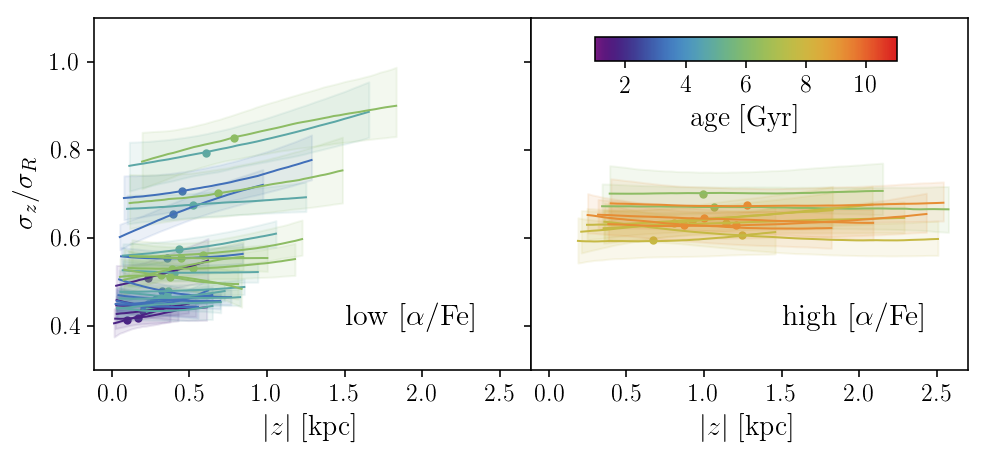

In [9]:
agegrid = (np.ones([len(agebins)-1, len(fehbins)-1]).T*((agebins[1:]+agebins[:-1])/2.)).T
fehgrid = (np.ones([len(agebins)-1, len(fehbins)-1])*((fehbins[1:]+fehbins[:-1])/2.))


def sigma_profile(zs, a,b,c,med_z):
    prof = a*(zs-med_z)**2+b*(zs-med_z)+c
    return prof

def gen_sigma_profs(samples, med_z):
    zs = np.linspace(med_z[0], med_z[4], 50)
    profs = np.zeros([len(samples),len(zs)])
    mz = med_z[2]
    for i in range(len(samples)):
            profs[i] = sigma_profile(zs, samples[i,6], samples[i,7], 10**samples[i,5], mz)/sigma_profile(zs, samples[i,2], samples[i,3], 10**samples[i,1], mz)
    return zs, profs
  
norm = matplotlib.colors.Normalize(
    vmin=1.,
    vmax=11.)

# choose a colormap
c_m = matplotlib.cm.viridis

# create a ScalarMappable and initialize a data structure
s_m = matplotlib.cm.ScalarMappable(cmap=cm_rainbow, norm=norm)
s_m.set_array([])   

fig,ax = plt.subplots(1,2, sharex=True, sharey=True)
fig.set_size_inches(textwidth,columnwidth)
for i in range(len(agebins)-1):
    for j in range(len(fehbins)-1):
        if lo_nbins[i,j] > 300 :
            zs, profs = gen_sigma_profs(lo_samples[i,j], lo_med_z[i,j])
            ax[0].plot(zs, np.median(profs, axis=0), color=s_m.to_rgba(agegrid[i,j]))
            ax[0].fill_between(zs, np.percentile(profs, 16, axis=0), np.percentile(profs, 84, axis=0), color=s_m.to_rgba(agegrid[i,j]), alpha=0.1)
            ax[0].scatter(lo_med_z[i,j,2], 10**np.median(lo_samples[i,j,:,5])/10**np.median(lo_samples[i,j,:,1]), color=s_m.to_rgba(agegrid[i,j]), s=10)
        if hi_nbins[i,j] > 300:
            zs, profs = gen_sigma_profs(hi_samples[i,j], hi_med_z[i,j])
            ax[1].plot(zs, np.median(profs, axis=0), color=s_m.to_rgba(agegrid[i,j]))
            ax[1].fill_between(zs, np.percentile(profs, 16, axis=0), np.percentile(profs, 84, axis=0), color=s_m.to_rgba(agegrid[i,j]), alpha=0.1)
            ax[1].scatter(hi_med_z[i,j,2], 10**np.median(hi_samples[i,j,:,5])/10**np.median(hi_samples[i,j,:,1]), color=s_m.to_rgba(agegrid[i,j]), s=10)

ax[0].set_xlabel(r'$|z|\ \mathrm{[kpc]}$')
ax[1].set_xlabel(r'$|z|\ \mathrm{[kpc]}$')


ax[0].set_ylabel(r'$\sigma_{z}/\sigma_{R}$')
ax[0].set_ylim(0.3,1.1)
ax[0].text(1.5,0.4,r'$\mathrm{low\ [\alpha/Fe]}$', fontsize=15)
ax[1].text(1.5,0.4,r'$\mathrm{high\ [\alpha/Fe]}$', fontsize=15)



fig.tight_layout()
fig.subplots_adjust(wspace=0.)
cax= fig.add_axes([0.6,0.85,0.3,0.05])
plt.colorbar(s_m, cax=cax,label=r'$\mathrm{age\ [Gyr]}$', orientation='horizontal')

plt.savefig('../plots/sigmazR_fz_combined_DR2_astronn_dist.png', format='png', dpi=400)
plt.savefig('../plots/sigmazR_fz_combined_DR2_astronn_dist.pdf', format='pdf', dpi=400)





In [23]:
#now load the results for the varying v0 model

if os.path.isfile('../sav/apdr14gaiadr2_astroNN_ages_distances_ellipsoid_varyv0_monoage_sgrvsun.npy'):
    with open('../sav/apdr14gaiadr2_astroNN_ages_distances_ellipsoid_varyv0_monoage_sgrvsun.npy', 'rb') as f:
        lo_samples = np.load(f)
        hi_samples = np.load(f)
        co_samples = np.load(f)
        lo_med_z = np.load(f)
        hi_med_z = np.load(f)
        co_med_z = np.load(f)
        
agebins = np.arange(1.,14.,1.5)
fehbins = np.arange(-0.6,0.6,0.1)

lo_par = np.empty([len(agebins)-1,len(fehbins)-1,13,3])
hi_par = np.empty([len(agebins)-1,len(fehbins)-1,13,3])
co_par = np.empty([len(agebins)-1,len(fehbins)-1,13,3])
for i in range(len(agebins)-1):
    for j in range(len(fehbins)-1):
        lo_par[i,j] = np.nanpercentile(lo_samples[i,j], [16,50,84], axis=0).T
        hi_par[i,j] = np.nanpercentile(hi_samples[i,j], [16,50,84], axis=0).T
        co_par[i,j] = np.nanpercentile(co_samples[i,j], [16,50,84], axis=0).T


/home/astjmack/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "



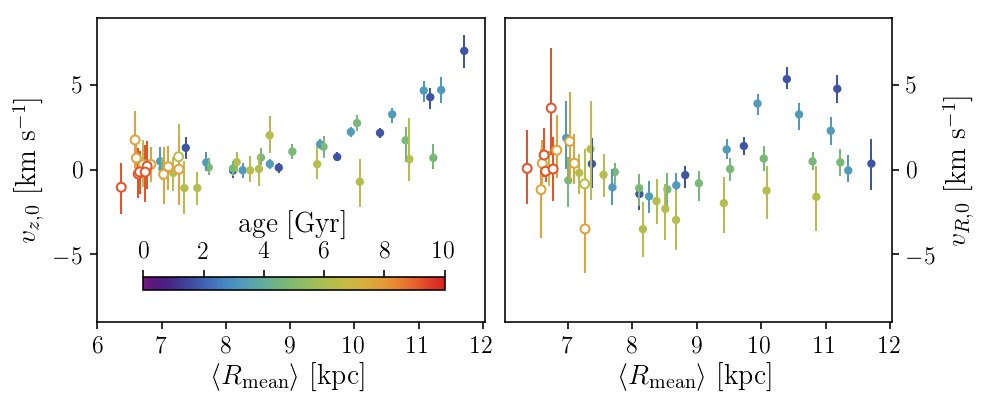

In [24]:
norm = matplotlib.colors.Normalize(
    vmin=0,
    vmax=10.)

# choose a colormap
c_m = matplotlib.cm.viridis

# create a ScalarMappable and initialize a data structure
s_m = matplotlib.cm.ScalarMappable(cmap=cm_rainbow, norm=norm)
s_m.set_array([]) 

fig, ax = plt.subplots(1,2, sharex=True)
fig.set_size_inches(1.*textwidth,0.9*columnwidth)
mask = lo_nbins.ravel() > 200
yerr = np.dstack([lo_par[:,:,11,1].ravel()[mask]-lo_par[:,:,11,0].ravel()[mask], lo_par[:,:,11,2].ravel()[mask]-lo_par[:,:,11,1].ravel()[mask]])[0].T
co_val = lo_par[:,:,11,1].ravel()[mask]
c = ax[0].scatter(lo_rmean.ravel()[mask]*8., co_val, s=10, c=s_m.to_rgba(agegrid.ravel()[mask]) )
ax[0].errorbar(lo_rmean.ravel()[mask]*8., co_val, yerr=yerr, fmt='None', ecolor=s_m.to_rgba(agegrid.ravel()[mask]), lw=1.)

mask = hi_nbins.ravel() > 200
yerr = np.dstack([hi_par[:,:,11,1].ravel()[mask]-hi_par[:,:,11,0].ravel()[mask], hi_par[:,:,11,2].ravel()[mask]-hi_par[:,:,11,1].ravel()[mask]])[0].T
co_val = hi_par[:,:,11,1].ravel()[mask]
c = ax[0].scatter(hi_rmean.ravel()[mask]*8., co_val, s=20, edgecolor=s_m.to_rgba(agegrid.ravel()[mask]), facecolor='White', zorder=2)
ax[0].errorbar(hi_rmean.ravel()[mask]*8., co_val, yerr=yerr, fmt='None', ecolor=s_m.to_rgba(agegrid.ravel()[mask]), lw=1., zorder=1)
#ax[0].colorbar(s_m, label=r'$\mathrm{age\ [Gyr]}$')
ax[0].set_ylabel(r'$v_{z,0}\ \mathrm{[km\ s^{-1}]}$')
ax[0].set_xlabel(r'$\langle R_{\mathrm{mean}}\rangle\ \mathrm{[kpc]}$')

mask = lo_nbins.ravel() > 200
yerr = np.dstack([lo_par[:,:,10,1].ravel()[mask]-lo_par[:,:,10,0].ravel()[mask], lo_par[:,:,10,2].ravel()[mask]-lo_par[:,:,10,1].ravel()[mask]])[0].T
co_val = lo_par[:,:,10,1].ravel()[mask]
c = ax[1].scatter(lo_rmean.ravel()[mask]*8., co_val, s=10, c=s_m.to_rgba(agegrid.ravel()[mask]) )
ax[1].errorbar(lo_rmean.ravel()[mask]*8., co_val, yerr=yerr, fmt='None', ecolor=s_m.to_rgba(agegrid.ravel()[mask]), lw=1.)

mask = hi_nbins.ravel() > 200
yerr = np.dstack([hi_par[:,:,10,1].ravel()[mask]-hi_par[:,:,10,0].ravel()[mask], hi_par[:,:,10,2].ravel()[mask]-hi_par[:,:,10,1].ravel()[mask]])[0].T
co_val = hi_par[:,:,10,1].ravel()[mask]
c = ax[1].scatter(hi_rmean.ravel()[mask]*8., co_val, s=20, edgecolor=s_m.to_rgba(agegrid.ravel()[mask]), facecolor='White', zorder=2)
ax[1].errorbar(hi_rmean.ravel()[mask]*8., co_val, yerr=yerr, fmt='None', ecolor=s_m.to_rgba(agegrid.ravel()[mask]), lw=1., zorder=1)

ax[1].set_ylabel(r'$v_{R,0}\ \mathrm{[km\ s^{-1}]}$')
ax[1].set_xlabel(r'$\langle R_{\mathrm{mean}}\rangle\ \mathrm{[kpc]}$')
#plt.xticks([0.,2.,4,6.,8,10.])
#plt.xlim(0.,11.)
ax[1].yaxis.tick_right()
ax[1].yaxis.set_label_position('right')

ax[0].set_ylim(-9,9)
ax[1].set_ylim(-9,9)
ax[0].set_xticks([6,7,8,9,10,11,12])
cax = fig.add_axes([0.15,0.3,0.3,0.03])
cb = plt.colorbar(s_m, label=r'$\mathrm{age\ [Gyr]}$', orientation='horizontal', cax=cax)
cb.ax.xaxis.set_ticks_position('top')
cb.ax.xaxis.set_label_position('top')
fig.tight_layout()
fig.subplots_adjust(wspace=0.05)
plt.savefig('../plots/vRz0_Rmean_age.pdf', format='pdf', dpi=400, bbox_inches='tight')
plt.savefig('../plots/vRz0_Rmean_age.png', format='png', dpi=400, bbox_inches='tight')



